In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Load dataset
data = load_breast_cancer()
X = data.data          # features
y = data.target        # labels
feature_names = data.feature_names

# Normalize features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Data shape:", X_scaled.shape)
print("Target shape:", y.shape)


Data shape: (569, 30)
Target shape: (569,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=67, shuffle=True
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Training samples: 398
Test samples: 171


Training accuracy: 0.9874
Test accuracy: 0.9708


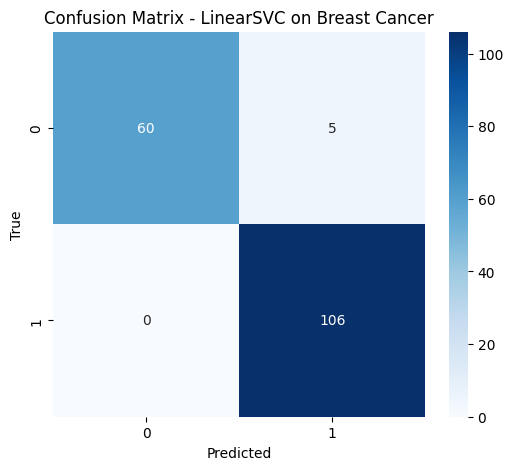

In [11]:
# LinearSVC can need more iterations for convergence
model = LinearSVC(random_state=4, max_iter=10000)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Training accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LinearSVC on Breast Cancer')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [12]:
n_features = X_scaled.shape[1]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

selected_features_forward = []
remaining_features = list(range(n_features))
forward_scores = []
print("\n--- Forward Greedy Feature Selection ---")
for _ in range(n_features):
    best_score = 0
    best_feature = None
    for f in remaining_features:
        features_to_try = selected_features_forward + [f]
        model = LinearSVC(max_iter=10000, random_state=4)
        scores = cross_val_score(model, X_train[:, features_to_try], y_train, cv=kf)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_feature = f
    selected_features_forward.append(best_feature)
    remaining_features.remove(best_feature)
    forward_scores.append(best_score)
    print(f"Step {_+1}: add feature {feature_names[best_feature]}, CV accuracy = {best_score:.4f}")



--- Forward Greedy Feature Selection ---
Step 1: add feature worst radius, CV accuracy = 0.9094
Step 2: add feature worst smoothness, CV accuracy = 0.9547
Step 3: add feature worst texture, CV accuracy = 0.9724
Step 4: add feature worst area, CV accuracy = 0.9774
Step 5: add feature mean fractal dimension, CV accuracy = 0.9799
Step 6: add feature area error, CV accuracy = 0.9799
Step 7: add feature concavity error, CV accuracy = 0.9799
Step 8: add feature fractal dimension error, CV accuracy = 0.9799
Step 9: add feature mean concavity, CV accuracy = 0.9800
Step 10: add feature radius error, CV accuracy = 0.9825
Step 11: add feature mean compactness, CV accuracy = 0.9825
Step 12: add feature symmetry error, CV accuracy = 0.9825
Step 13: add feature mean radius, CV accuracy = 0.9800
Step 14: add feature mean texture, CV accuracy = 0.9800
Step 15: add feature worst symmetry, CV accuracy = 0.9850
Step 16: add feature mean smoothness, CV accuracy = 0.9850
Step 17: add feature mean symmetry

In [13]:
selected_features_backward = list(range(n_features))
backward_scores = []
removed_features = []
for _ in range(n_features-1):
    best_score = 0
    worst_feature = None
    for f in selected_features_backward:
        features_to_try = [feat for feat in selected_features_backward if feat != f]
        model = LinearSVC(max_iter=10000, random_state=4)
        scores = cross_val_score(model, X_train[:, features_to_try], y_train, cv=kf)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            worst_feature = f
    selected_features_backward.remove(worst_feature)
    removed_features.append(worst_feature)
    backward_scores.append(best_score)
    print(f"Step {_+1}: remove feature {feature_names[worst_feature]}, CV accuracy = {best_score:.4f}")
top6_backward = [f for f in range(n_features) if f not in removed_features[:n_features-6]]
print("Top 6 features (Backward Selection):", feature_names[top6_backward])


Step 1: remove feature mean radius, CV accuracy = 0.9825
Step 2: remove feature mean texture, CV accuracy = 0.9825
Step 3: remove feature mean perimeter, CV accuracy = 0.9825
Step 4: remove feature mean area, CV accuracy = 0.9825
Step 5: remove feature mean smoothness, CV accuracy = 0.9825
Step 6: remove feature mean compactness, CV accuracy = 0.9825
Step 7: remove feature mean concave points, CV accuracy = 0.9825
Step 8: remove feature mean symmetry, CV accuracy = 0.9825
Step 9: remove feature radius error, CV accuracy = 0.9825
Step 10: remove feature texture error, CV accuracy = 0.9825
Step 11: remove feature mean fractal dimension, CV accuracy = 0.9825
Step 12: remove feature area error, CV accuracy = 0.9850
Step 13: remove feature symmetry error, CV accuracy = 0.9850
Step 14: remove feature fractal dimension error, CV accuracy = 0.9850
Step 15: remove feature worst compactness, CV accuracy = 0.9850
Step 16: remove feature concavity error, CV accuracy = 0.9850
Step 17: remove featur

In [14]:
top6_forward = selected_features_forward[:6]


print("\nTop 6 features (Forward Selection):", feature_names[top6_forward])
print("Top 6 features (Backward Selection):", feature_names[top6_backward])



Top 6 features (Forward Selection): ['worst radius' 'worst smoothness' 'worst texture' 'worst area'
 'mean fractal dimension' 'area error']
Top 6 features (Backward Selection): ['mean concavity' 'compactness error' 'worst radius' 'worst texture'
 'worst smoothness' 'worst symmetry']


0.9798717948717949 0.9824999999999999


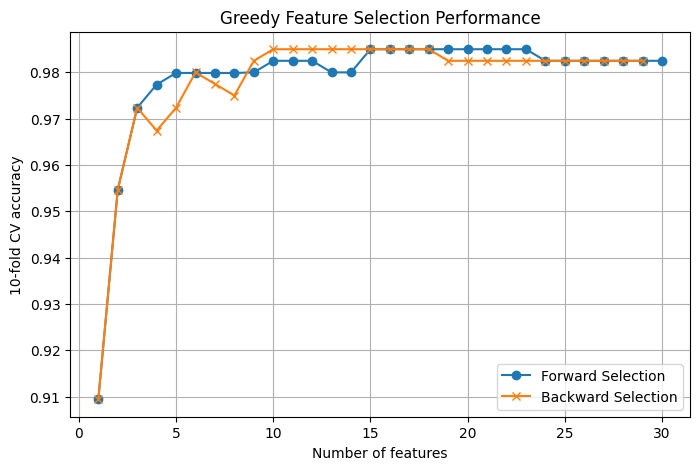

In [15]:
plt.figure(figsize=(8,5))
print(forward_scores[5], backward_scores[5])
plt.plot(range(1, n_features+1), forward_scores, marker='o', label='Forward Selection')
plt.plot(range(n_features-1, 0, -1), backward_scores, marker='x', label='Backward Selection')
plt.xlabel('Number of features')
plt.ylabel('10-fold CV accuracy')
plt.title('Greedy Feature Selection Performance')
plt.legend()
plt.grid(True)
plt.show()


Forward test accuracy with 6 features: 0.9415204678362573
Backward test accuracy with 6 features: 0.9473684210526315


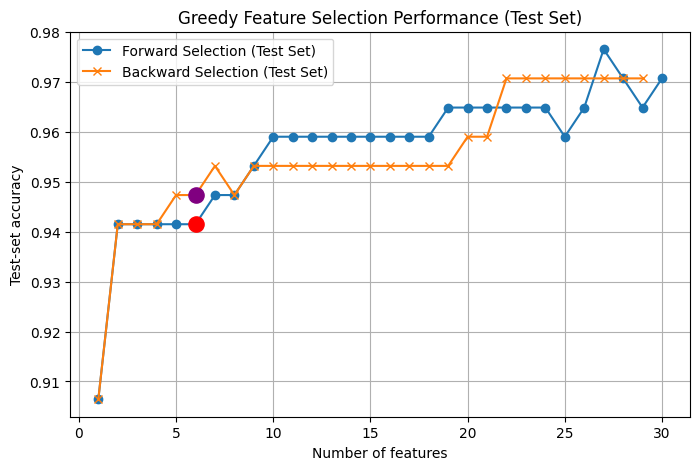

In [16]:
# --- Forward test scores ---
forward_test_scores = []

for k in range(1, n_features+1):
    subset = selected_features_forward[:k]
    model = LinearSVC(max_iter=10000, random_state=42)
    model.fit(X_train[:, subset], y_train)
    acc = model.score(X_test[:, subset], y_test)
    forward_test_scores.append(acc)

# --- Backward test scores ---
backward_test_scores = []

current_subset = list(range(n_features))

for removed in removed_features:
    current_subset = [f for f in current_subset if f != removed]
    model = LinearSVC(max_iter=10000, random_state=42)
    model.fit(X_train[:, current_subset], y_train)
    acc = model.score(X_test[:, current_subset], y_test)
    backward_test_scores.append(acc)

# Correct index for 6-feature backward result
idx_backward_6 = (n_features - 6) - 1

print("Forward test accuracy with 6 features:", forward_test_scores[5])
print("Backward test accuracy with 6 features:", backward_test_scores[idx_backward_6])

# --- Plot ---
plt.figure(figsize=(8,5))

# Forward curve
plt.plot(range(1, n_features+1),
         forward_test_scores,
         marker='o', label='Forward Selection (Test Set)')

# Backward curve
backward_x = list(range(n_features-1, 0, -1))
plt.plot(backward_x,
         backward_test_scores,
         marker='x', label='Backward Selection (Test Set)')

# Mark forward 6-feature point
plt.scatter(6, forward_test_scores[5], s=120, color='red', zorder=5)

# Mark backward 6-feature point
plt.scatter(6, backward_test_scores[idx_backward_6], s=120, color='purple', zorder=5)

plt.xlabel('Number of features')
plt.ylabel('Test-set accuracy')
plt.title('Greedy Feature Selection Performance (Test Set)')
plt.legend()
plt.grid(True)
plt.show()
